<h1>Import Statements</h1>

In [101]:
import numpy as np
import pandas as pd

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from matplotlib.pyplot import *

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

<h1>Data Loading...</h1>

In [102]:
oil_df = pd.read_csv("data/oil_price.csv", header = 0, index_col = 0)

oil_df.index = pd.to_datetime(oil_df.index)

oil_df.head(10)

,Price
Date,
2020-07-01,42.18
2020-07-02,43.19
2020-07-03,42.92
2020-07-06,42.73
2020-07-07,43.28
2020-07-08,43.67
2020-07-09,42.35
2020-07-10,43.27
2020-07-13,42.85


In [103]:
oil_df.describe(include = "all")

,Price
count,635.000000
mean,77.214110
std,23.898162
min,36.330000
25%,61.130000
50%,75.500000
75%,94.275000
max,133.180000


<h1>Data Cleaning</h1>

In [104]:
print(oil_df.count(), "\n")
print(oil_df.notna().count())

Price    635
dtype: int64 

Price    1230
dtype: int64


In [105]:
# Dropping null columns
cleaned_df = oil_df.dropna(how = "any")

In [106]:
print(oil_df.count(), "\n")
print(oil_df.notna().count())

Price    635
dtype: int64 

Price    1230
dtype: int64


In [107]:
print(f"Date range: {cleaned_df.index[0]} to {cleaned_df.index[-1]}")

Date range: 2020-07-01 00:00:00 to 2022-12-30 00:00:00


<h1>Exploratory Data Analysis</h1>

In [108]:
def make_ts_plot(price_series: pd.Series, index: pd.Series = cleaned_df.index) -> None:
	"""
		Plotting the time series price chart 
		for different transformations 
		of the Price column
	"""
	figure(figsize = (10, 5))
	plot(index, price_series)

	title("Oil Price Chart from mid year 2020 to the end of year 2022")

	xticks(rotation = 45)
	tight_layout()
	show()

In [109]:
def make_hist_plot(price_series: pd.Series) -> None:
	"""
		Plotting the time series histogram 
		for different transformations 
		of the Price column
	"""
	hist(price_series)
	show()

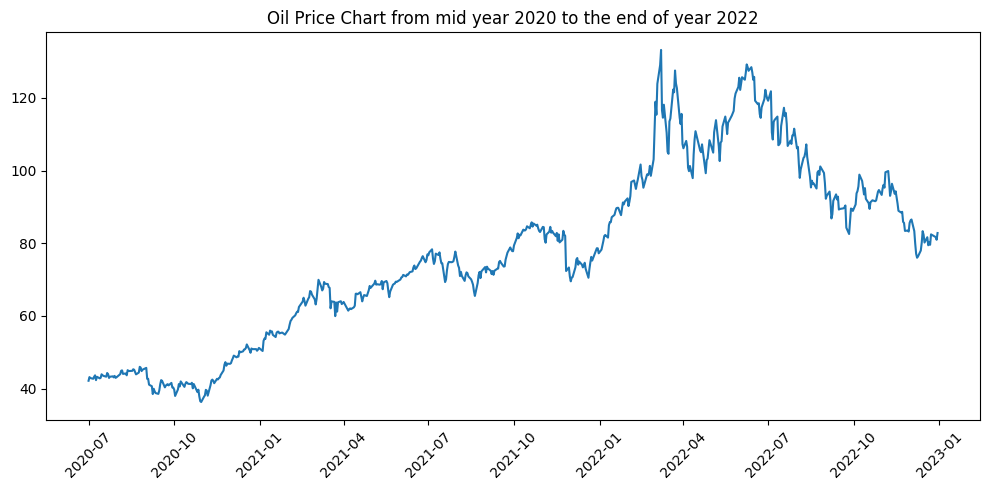

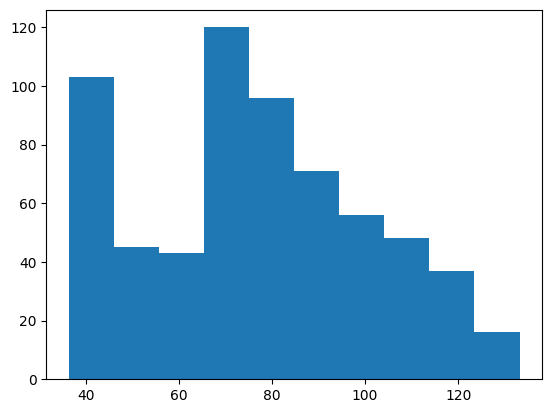

In [110]:
make_ts_plot(cleaned_df["Price"])
make_hist_plot(cleaned_df["Price"])

<h1>Method 1 - AutoRegressive Integrated Moving Averages (ARIMA)</h1>

Testing For Stationarity

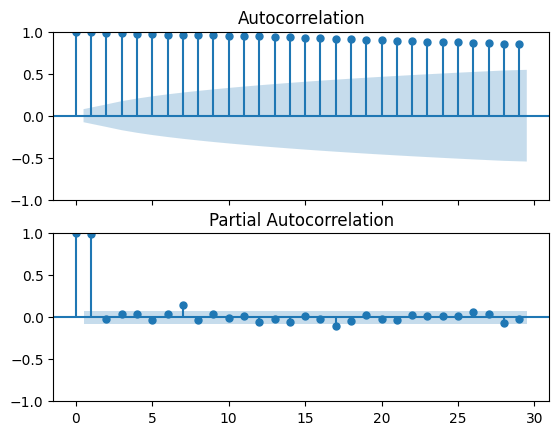

In [111]:
fig, ax = subplots(2, 1, sharex = True)
plot_acf(cleaned_df["Price"][1:], ax = ax[0])
plot_pacf(cleaned_df["Price"][1:], ax = ax[1], method = "ywm")
show()

In [112]:
cleaned_df.loc[:, "Price_Boxcox"], lam = boxcox(cleaned_df["Price"])

print(f"Best transformation is: {lam}")

Best transformation is: 0.6161794129942915


/var/folders/7n/5wfxxtqx41zcc7qqdj_8rcl80000gn/T/ipykernel_20326/3069749049.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.loc[:, "Price_Boxcox"], lam = boxcox(cleaned_df["Price"])


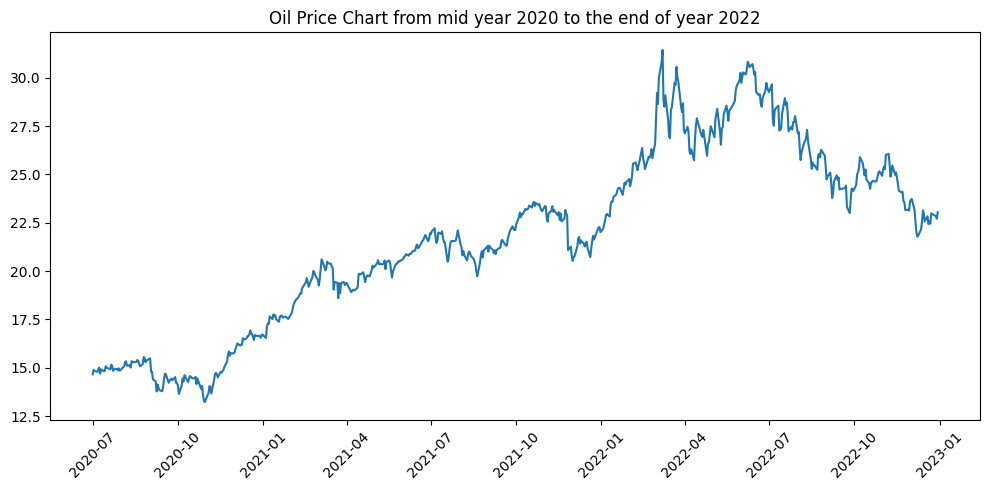

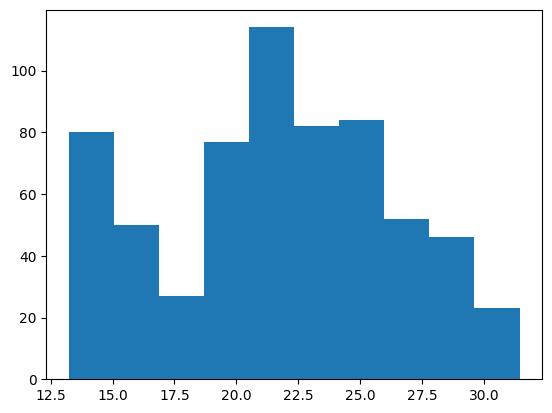

In [113]:
make_ts_plot(cleaned_df["Price_Boxcox"])
make_hist_plot(cleaned_df["Price_Boxcox"])

In [114]:
cleaned_df.loc[:, "Price_Diff"] = cleaned_df.loc[:, "Price_Boxcox"].diff().dropna()

/var/folders/7n/5wfxxtqx41zcc7qqdj_8rcl80000gn/T/ipykernel_20326/2894682567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.loc[:, "Price_Diff"] = cleaned_df.loc[:, "Price_Boxcox"].diff().dropna()


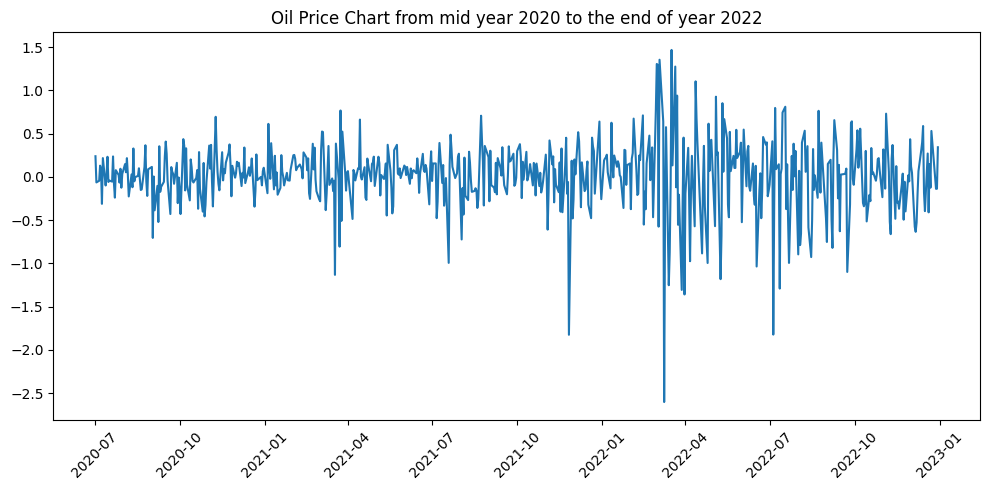

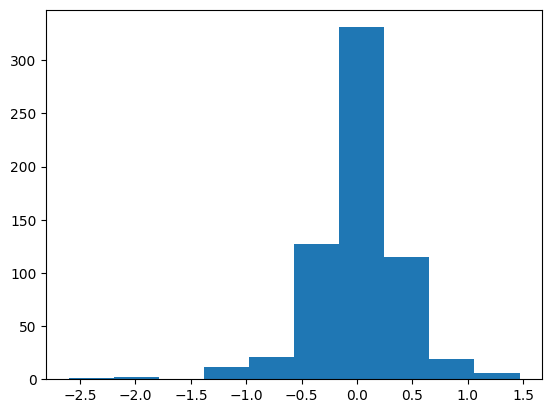

In [115]:
make_ts_plot(cleaned_df["Price_Diff"])
make_hist_plot(cleaned_df["Price_Diff"])

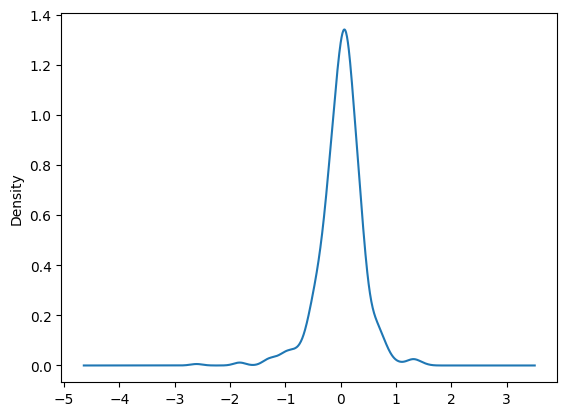

In [116]:
cleaned_df["Price_Diff"].plot(kind = 'kde')
show()

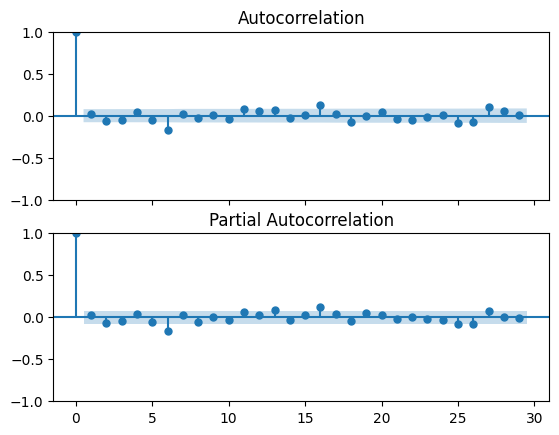

In [117]:
fig, ax = subplots(2, 1, sharex = True)
plot_acf(cleaned_df["Price_Diff"][1:], ax = ax[0])
plot_pacf(cleaned_df["Price_Diff"][1:], ax = ax[1], method = "ywm")
show()

In [118]:
adf_stat, p, *_ = adfuller(cleaned_df["Price_Diff"].dropna())
print(f"ADF statistic = {adf_stat:.3f},  p-value = {p:.3g}")

ADF statistic = -5.240,  p-value = 7.28e-06


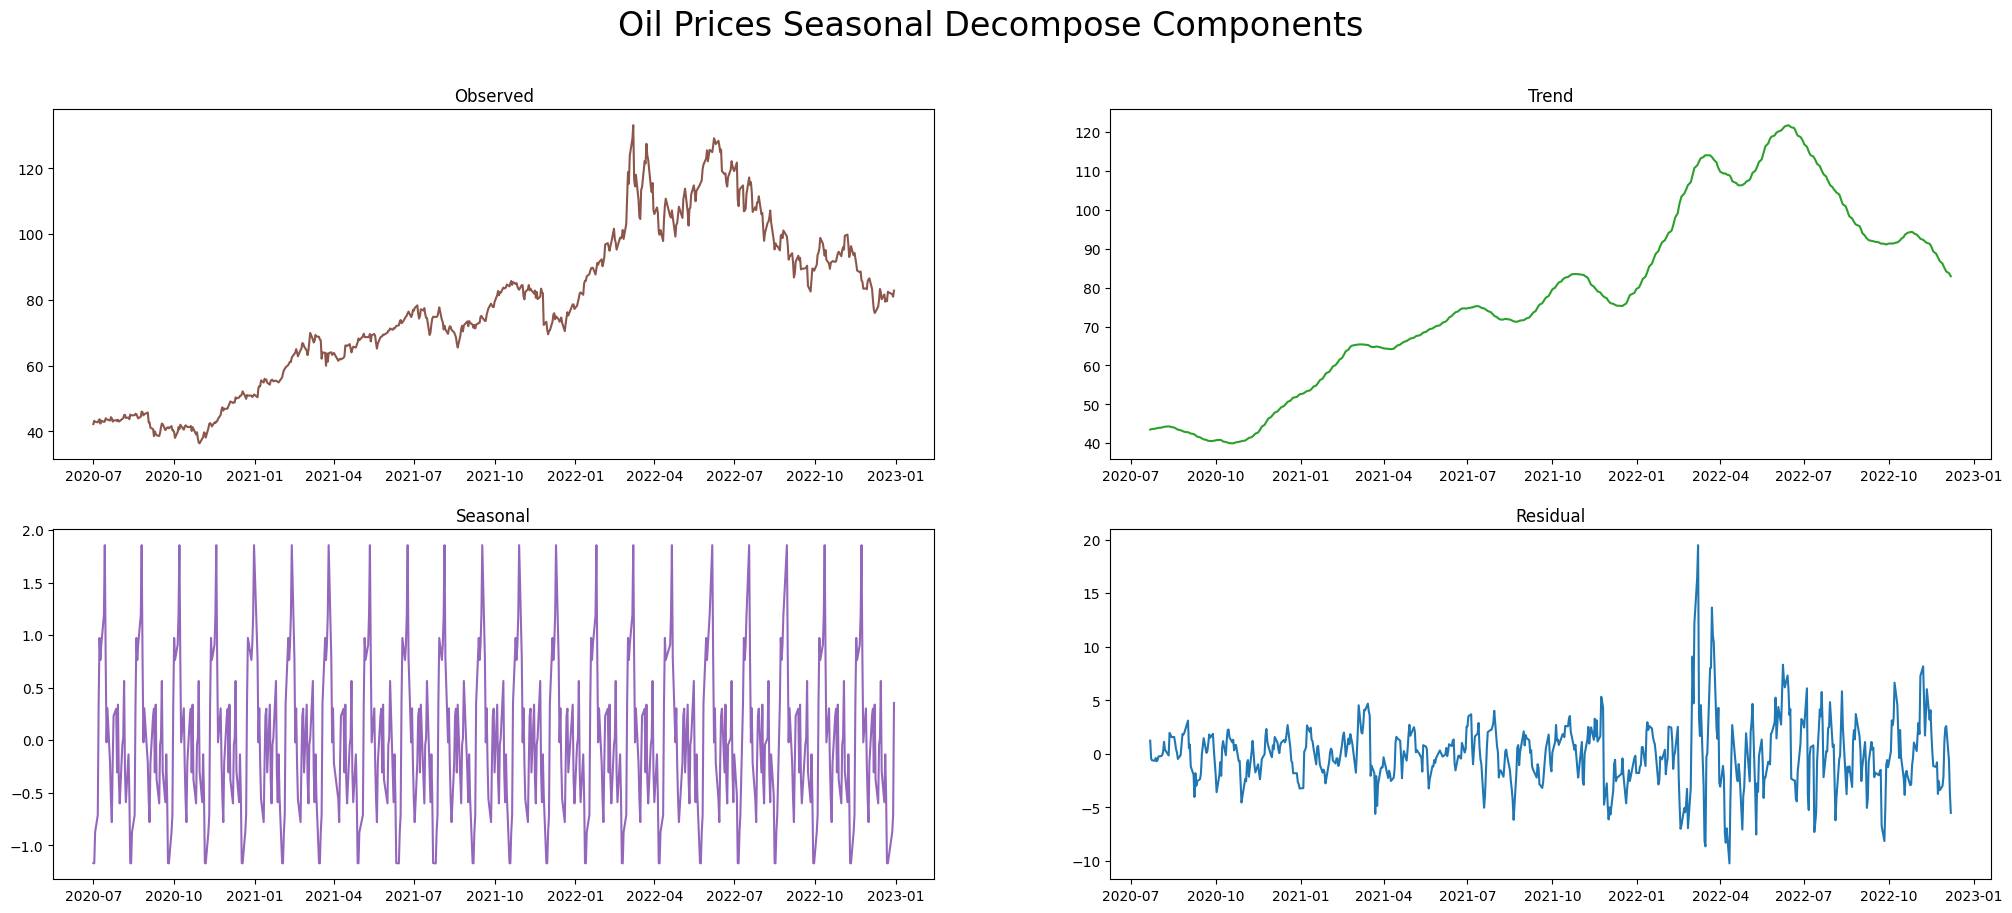

In [119]:
decomp = seasonal_decompose(cleaned_df["Price"], model = "additive", period = 30)
fig, ax = subplots(2, 2, figsize = (25, 10))

components = [decomp.observed, decomp.trend, decomp.seasonal, decomp.resid]
labels = ["Observed", "Trend", "Seasonal", "Residual"]
colors = ["C5", "C2", "C4", "C0"]

for i in range(2):
    for j in range(2):
        ax[i][j].plot(components[2 * i + j], color = colors[2 * i + j])
        ax[i][j].set_title(labels[2 * i + j])

fig.suptitle("Oil Prices Seasonal Decompose Components", fontsize = 24)

show()

### From the above we can sense a lack of exact seasonality and clear trend direction.

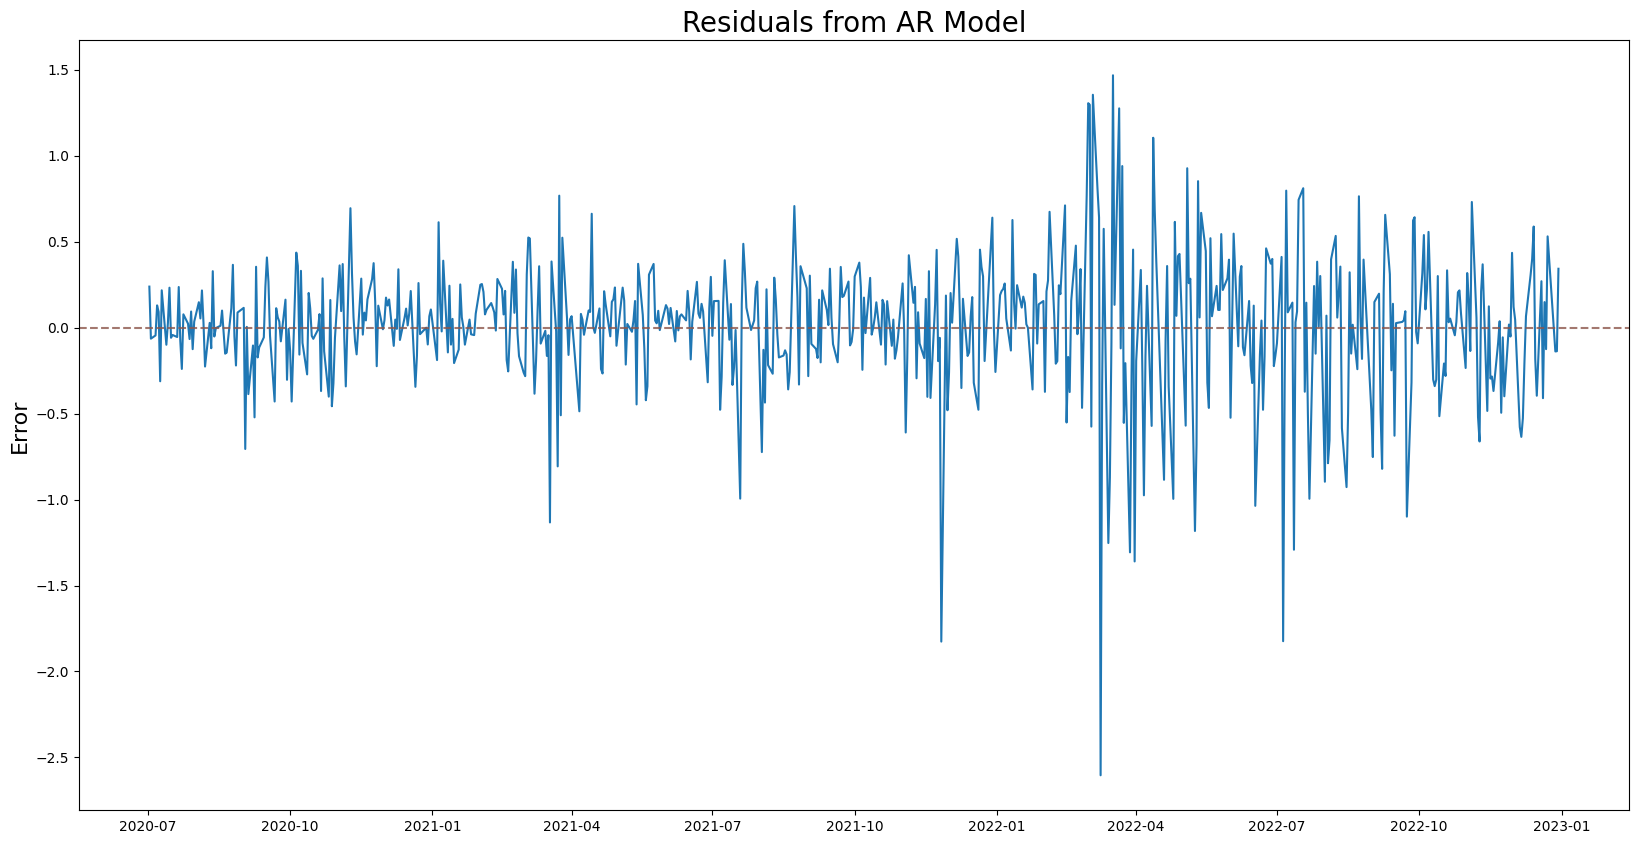

In [120]:
# plot the residuals

residuals = cleaned_df["Price_Diff"]

figure(figsize = (20, 10))

plot(residuals)
title('Residuals from AR Model', fontsize = 20)
ylabel('Error', fontsize = 16)
axhline(0, color = 'C5', linestyle = '--', alpha = 0.8)
show()

In [121]:
# Testing random models 

arma_model = ARIMA(residuals[1:], order = (1, 0, 1))

arma_model_fit = arma_model.fit()

aic = arma_model_fit.aic

print(f"The AIC for ARIMA (1, 0, 1) model is: {aic}")

/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


The AIC for ARIMA (1, 0, 1) model is: 621.4504166583358


In [27]:
# Looking for lowest AIC

aic_results = []
for p in range(0, 8):
	for d in range(0, 2):
		for q in range(0, 8):
			try:
				model = ARIMA(residuals, order = (p, d, q))
				model_fit = model.fit()
				aic_results.append({'order': (p, d, q), 'aic': model_fit.aic})
			except Exception as e:
				continue

best_result = min(aic_results, key = lambda x: x['aic'])
print(f"Best order: {best_result['order']}, AIC: {best_result['aic']}")

/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as sta

Best order: (6, 0, 7), AIC: 599.6757586612235


/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [122]:
# Since our best order is (6, 0, 7) with AIC: 599.6757586612235

arma_model = ARIMA(residuals[1:], order = (6, 0, 7))

arma_model_fit = arma_model.fit()

aic = arma_model_fit.aic

/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Lik

In [123]:
print(arma_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Price_Diff   No. Observations:                  634
Model:                 ARIMA(6, 0, 7)   Log Likelihood                -284.838
Date:                Mon, 07 Jul 2025   AIC                            599.676
Time:                        05:11:15   BIC                            666.456
Sample:                             0   HQIC                           625.608
                                - 634                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0128      0.014      0.906      0.365      -0.015       0.041
ar.L1          0.0820      0.114      0.718      0.473      -0.142       0.306
ar.L2          0.4197      0.118      3.553      0.0

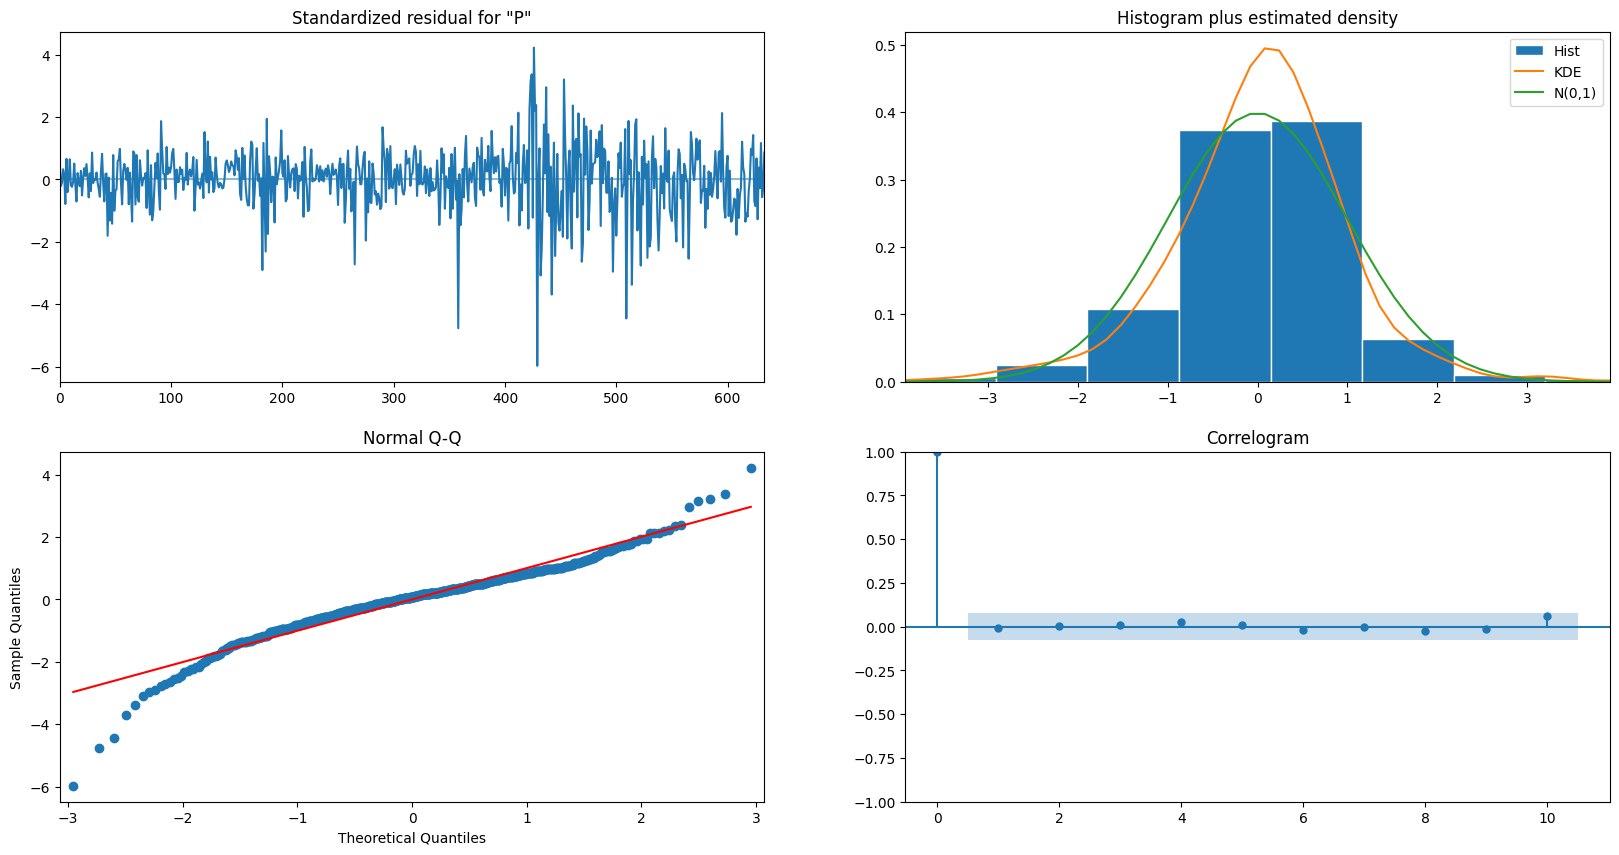

In [124]:
arma_model_fit.plot_diagnostics(figsize = (20, 10))
show()

In [125]:
#get prediction start and end dates
test_data = cleaned_df.copy()

pred_start_date = test_data.index[1]
pred_end_date = test_data.index[-1]

#get the predictions and residuals
predictions = arma_model_fit.predict(start = pred_start_date, end = pred_end_date)
new_residuals = test_data.Price_Diff - predictions

# predictions, test_data.Price_Diff
# pred_start_date, pred_end_date

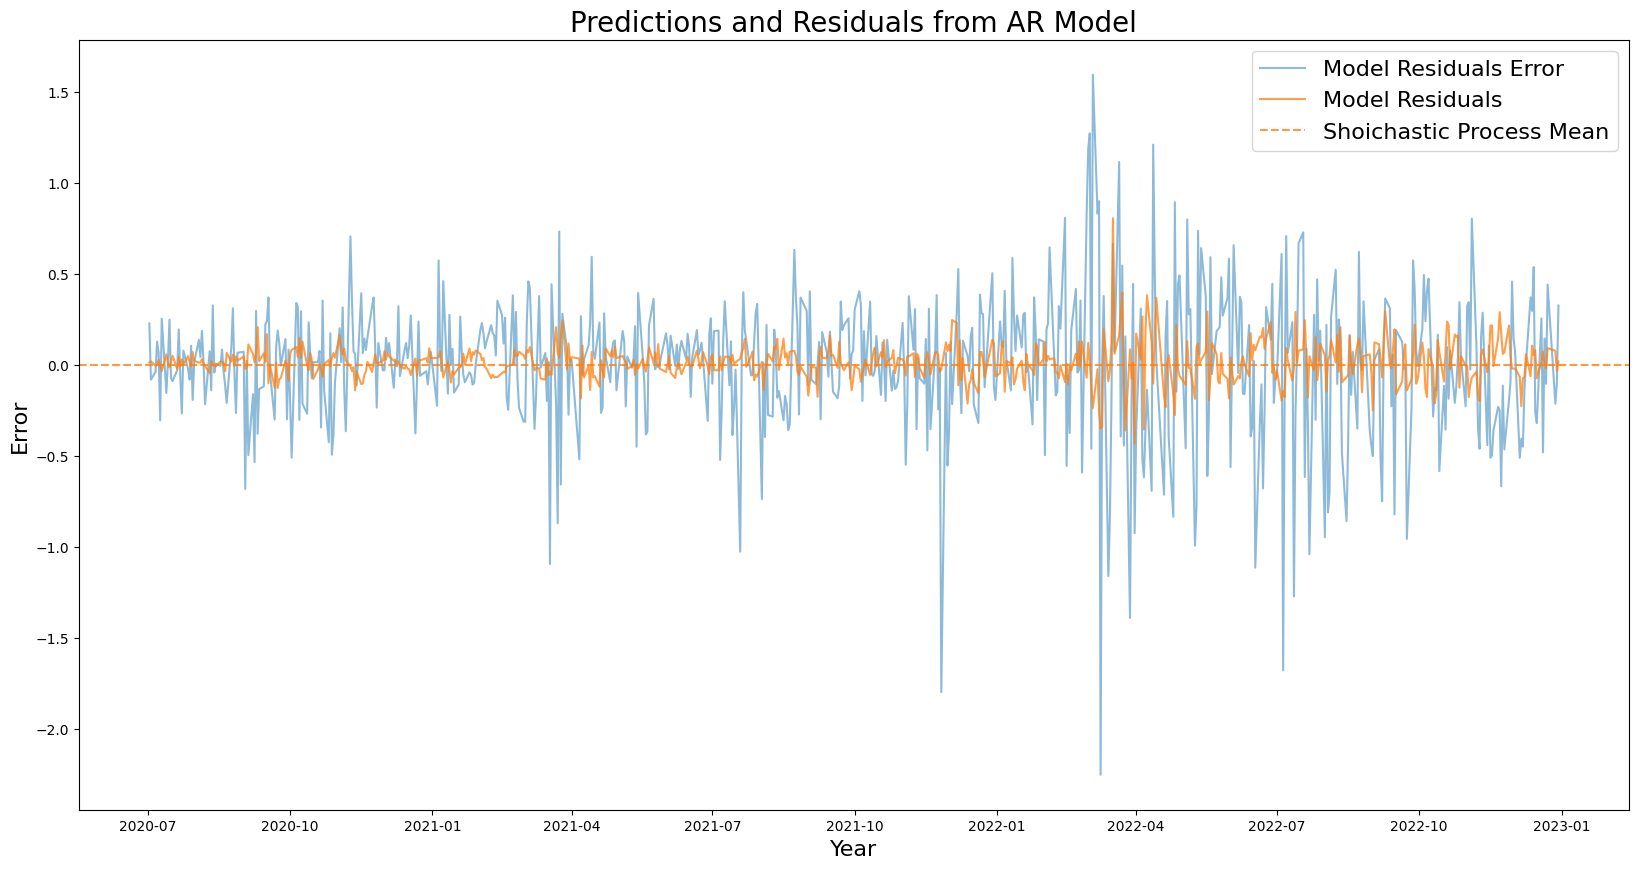

In [126]:
# Plot the model prediction against the data

figure(figsize = (20, 10))

plot(new_residuals, color = "C0", label = "Model Residuals Error", alpha = 0.5)
plot(predictions, color = "C1", label = "Model Residuals", alpha = 0.75)
axhline(0, color = 'C1', label = "Shoichastic Process Mean", linestyle = '--', alpha = 0.8)

title('Predictions and Residuals from AR Model', fontsize = 20)

ylabel('Error', fontsize = 16)
xlabel('Year', fontsize = 16)

legend(loc = "upper right", fontsize = 16)

show()

In [127]:
test_data["Price_Diff"] = test_data["Price_Diff"].fillna(0)

test_data.loc[:, "original_cs_usd"] = inv_boxcox(test_data["Price_Boxcox"].iloc[0] + test_data["Price_Diff"].cumsum(), lam)

test_data.loc[:, "original_shift_usd"] = inv_boxcox(test_data["Price_Diff"] + test_data["Price_Boxcox"].shift(1), lam)

test_data.loc[:, "prediction_cs_usd"] = inv_boxcox(predictions.cumsum() + test_data["Price_Boxcox"].iloc[0], lam)

test_data.loc[:, "prediction_shift_usd"] = inv_boxcox(predictions + test_data["Price_Boxcox"].shift(1), lam)

# test_data = test_data.drop(axis = 0, columns = ["original_bc", "original_usd", "prediction_usd", "original_cs_usd", "prediction_shift_usd"])

test_data.head(10)

,Price,Price_Boxcox,Price_Diff,original_cs_usd,original_shift_usd,prediction_cs_usd,prediction_shift_usd
Date,,,,,,,
2020-07-01,42.18,14.656932,0.000000,42.18,NaN,NaN,NaN
2020-07-02,43.19,14.896040,0.239108,43.19,43.19,42.234018,42.234018
2020-07-03,42.92,14.832332,-0.063708,42.92,42.92,42.312619,43.269279
2020-07-06,42.73,14.787409,-0.044924,42.73,42.73,42.289690,42.896945
2020-07-07,43.28,14.917242,0.129833,43.28,43.28,42.303141,42.743505
2020-07-08,43.67,15.008922,0.091680,43.67,43.67,42.413946,43.391780
2020-07-09,42.35,14.697331,-0.311591,42.35,42.35,42.390703,43.646494
2020-07-10,43.27,14.914887,0.217556,43.27,43.27,42.241978,42.201330
2020-07-13,42.85,14.815790,-0.099097,42.85,42.85,42.481024,43.511259


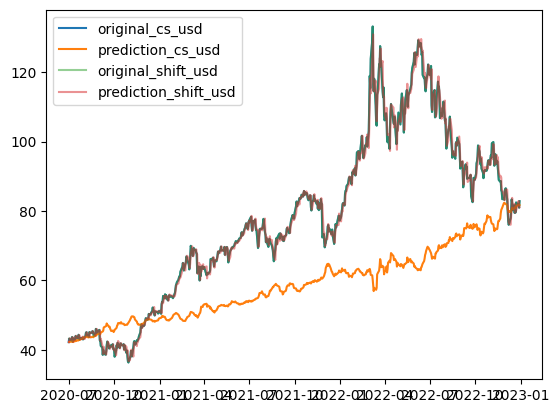

In [128]:
# price_usd = inv_boxcox((test_data["Price_Boxcox"].iloc[0] + test_data["Price_Diff"].fillna(0).cumsum()), lam)
# predictions_usd = inv_boxcox((test_data["Price_Boxcox"].iloc[0] + predictions.cumsum()), lam)
# residuals_usd = inv_boxcox((test_data["Price_Boxcox"].iloc[0] + new_residuals.cumsum()), lam)

plot(test_data["original_cs_usd"], label = "original_cs_usd")
plot(test_data["prediction_cs_usd"], label = "prediction_cs_usd")
plot(test_data["original_shift_usd"], label = "original_shift_usd", alpha = 0.5)
plot(test_data["prediction_shift_usd"], label = "prediction_shift_usd", alpha = 0.5)

legend()

show()

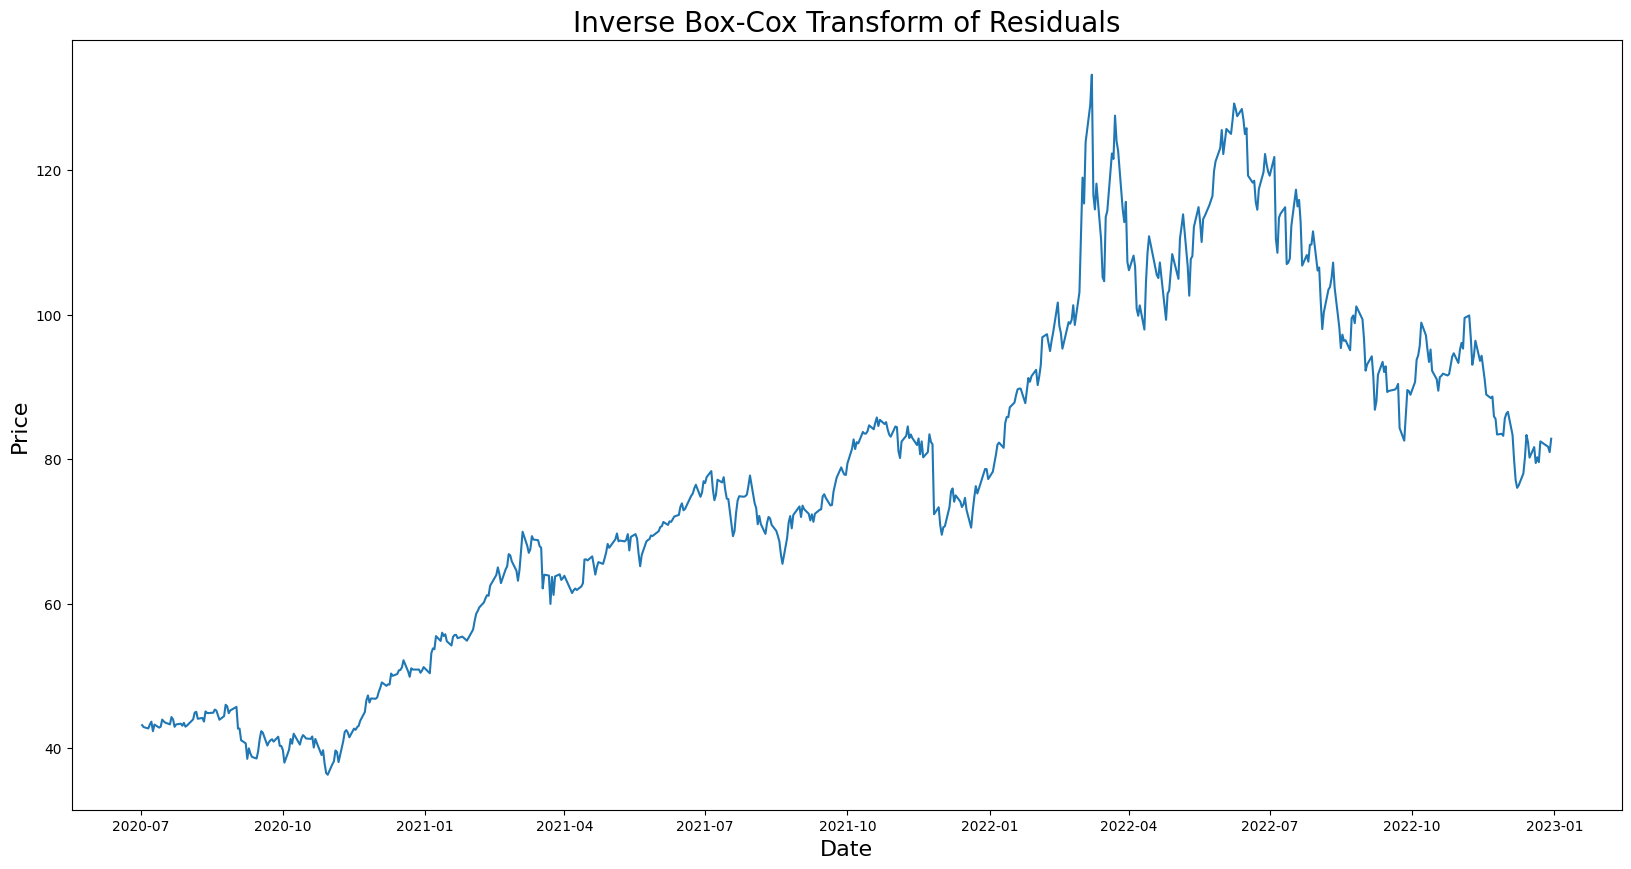

In [129]:
# Inverse Box-Cox transform of residuals
def inv_boxcox(y, lam):
	if lam == 0:
		return np.exp(y)
	else:
		return np.power(y * lam + 1, 1 / lam)

# Compute inverse transform (to original price scale)
inv_residuals = inv_boxcox(residuals + cleaned_df["Price_Boxcox"].shift(1), lam)

# Plot the inverse transformed residuals
figure(figsize = (20, 10))
plot(cleaned_df.index, inv_residuals)
title("Inverse Box-Cox Transform of Residuals", fontsize = 20)
ylabel("Price", fontsize = 16)
xlabel("Date", fontsize = 16)
show()

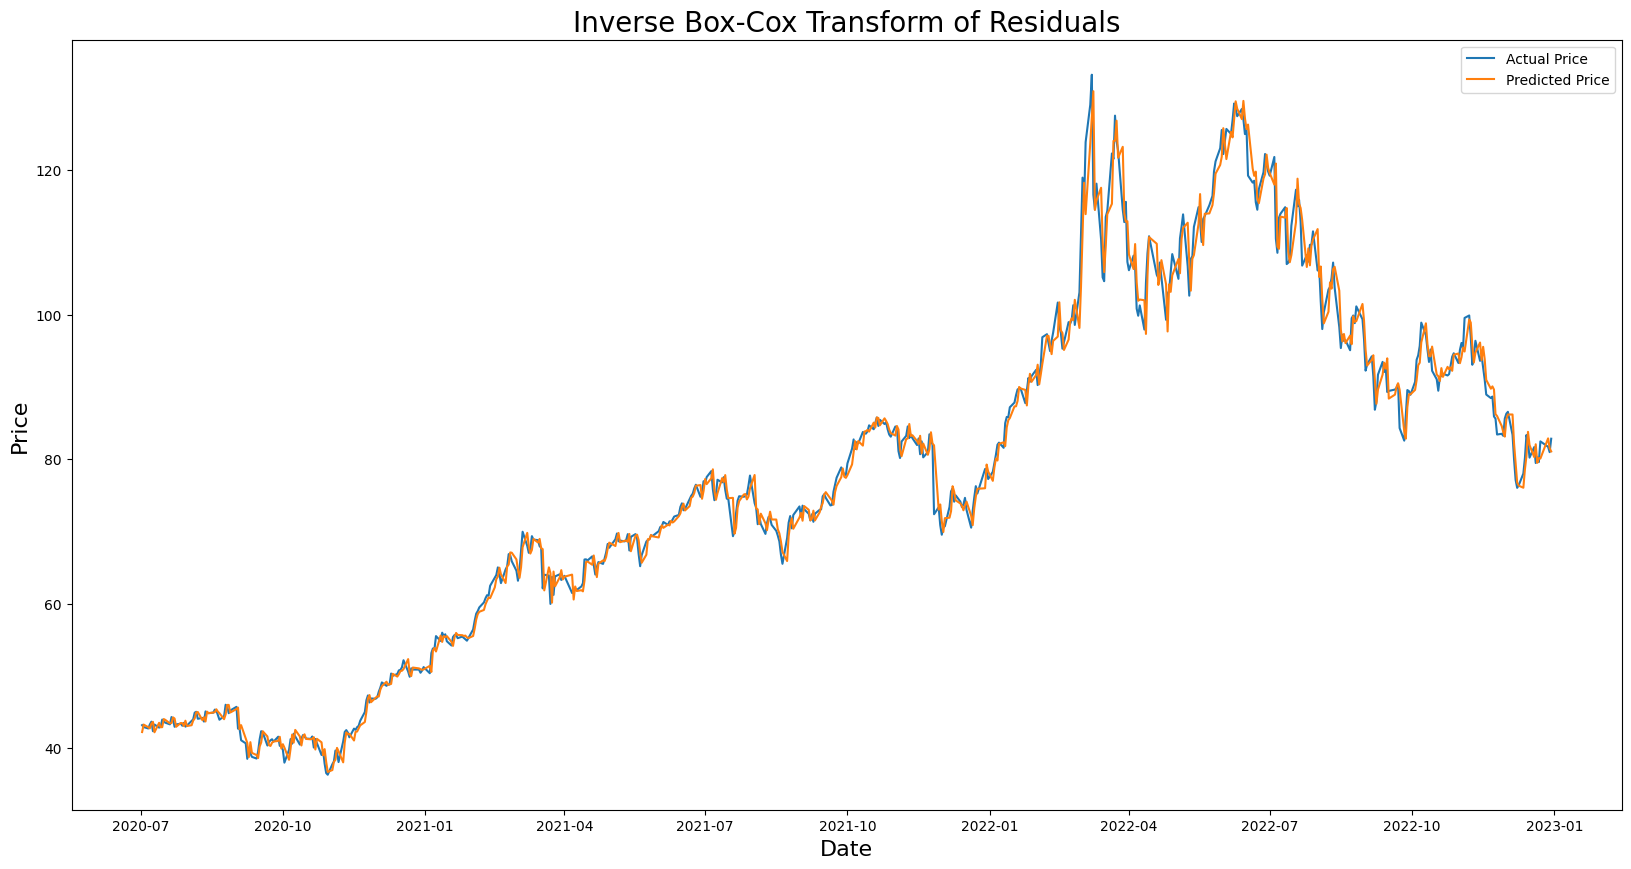

In [ ]:
# Compute inverse transform (to original price scale)
inv_predictions = inv_boxcox(predictions + cleaned_df["Price_Boxcox"].shift(1), lam)

# Plot the inverse transformed residuals
figure(figsize = (20, 10))
plot(cleaned_df.index, inv_residuals, label = "Actual Price")
plot(cleaned_df.index, inv_predictions, label = "Predicted Price")
title("Inverse Box-Cox Transform of Residuals", fontsize = 20)
ylabel("Price", fontsize = 16)
xlabel("Date", fontsize = 16)
legend()
show()

In [248]:
# Error:

rmse = np.sqrt(np.mean(residuals ** 2))
mae = np.mean(np.abs(residuals))

print(f"RMSE = {rmse:.2f}  MAE = {mae:.2f}")

RMSE = 0.39  MAE = 0.28


In [249]:
arma_model = ARIMA(residuals[1:], order = (6, 0, 7))

arma_model_fit = arma_model.fit()

/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Lik

/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


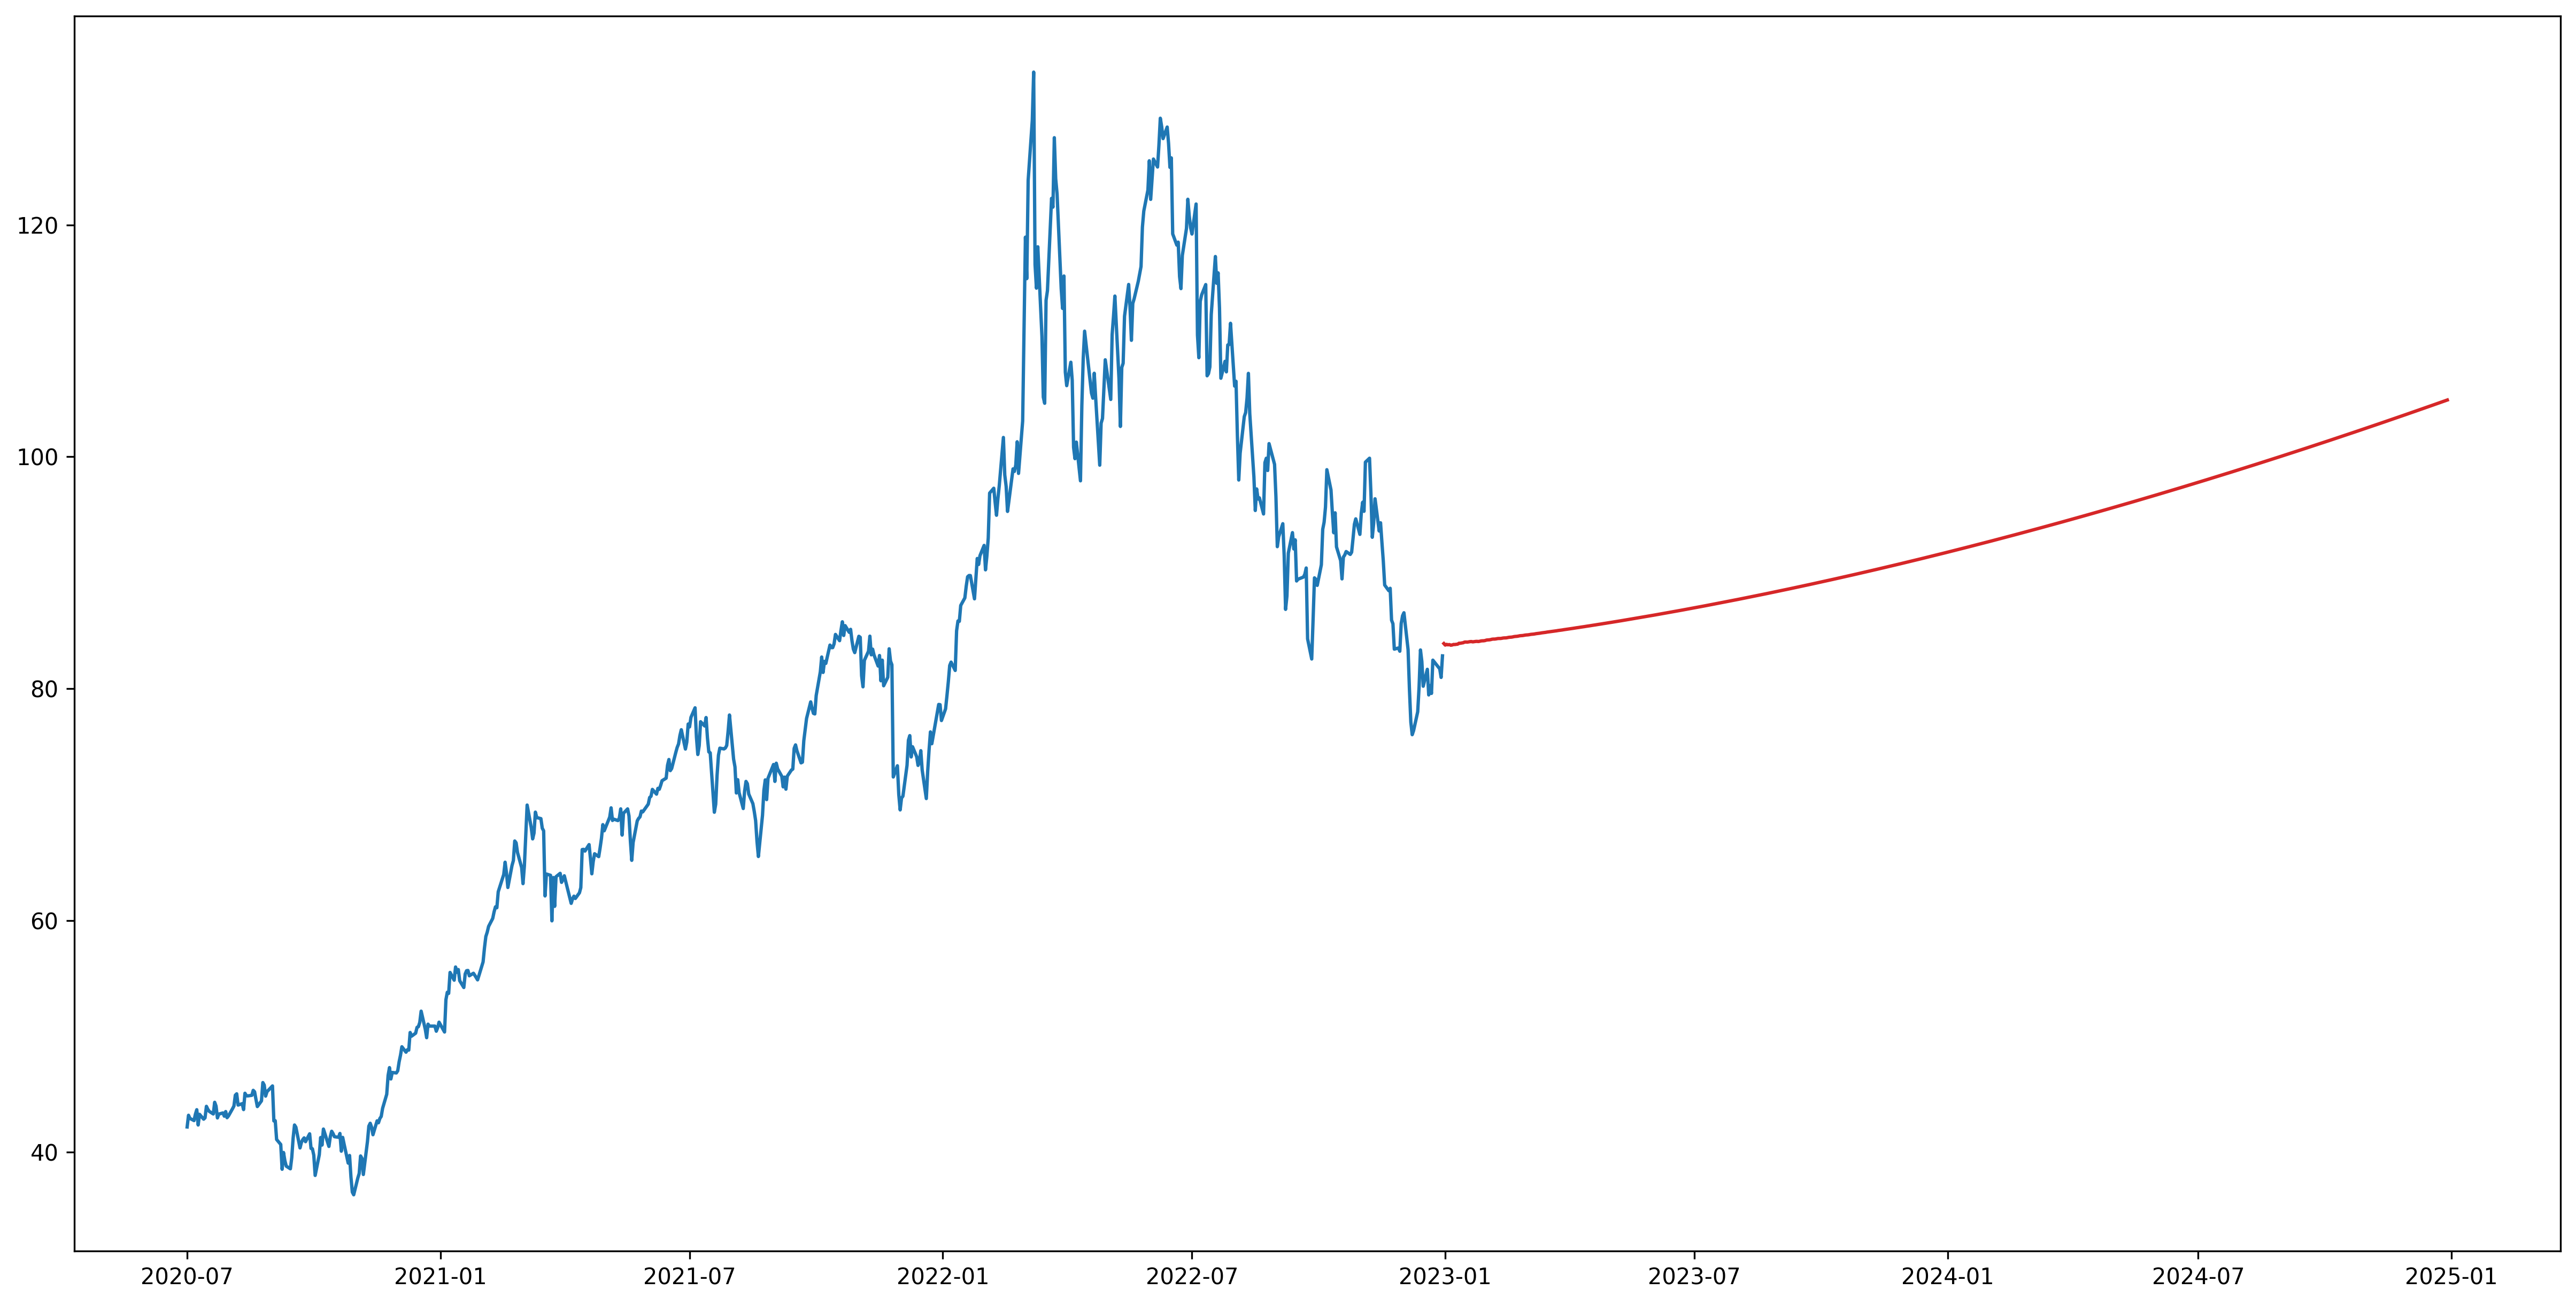

In [ ]:
n_forecast = 730 # The number of days in 24 months

# arma_model.nobs + n_forecast -> predicted index

predict = arma_model_fit.get_prediction(end = arma_model.nobs + n_forecast).predicted_mean

# last_boxcox = test_data["Price_Boxcox"].iloc[-1]

last_day = test_data.index[-1]

fc_date = pd.date_range(start = last_day + pd.Timedelta("1D"), periods = n_forecast, freq = "D")

fc_usd = cleaned_df["Price"].iloc[-1] + inv_boxcox(predict[-n_forecast:].cumsum(), lam)

figure(figsize = (20, 10), dpi = 300)

title("Recent Crude Oil Closing Prices")

plot(test_data["Price"], label = "Actual Price")
plot(fc_date, fc_usd, "C3", label = "Predicted Price")
show()

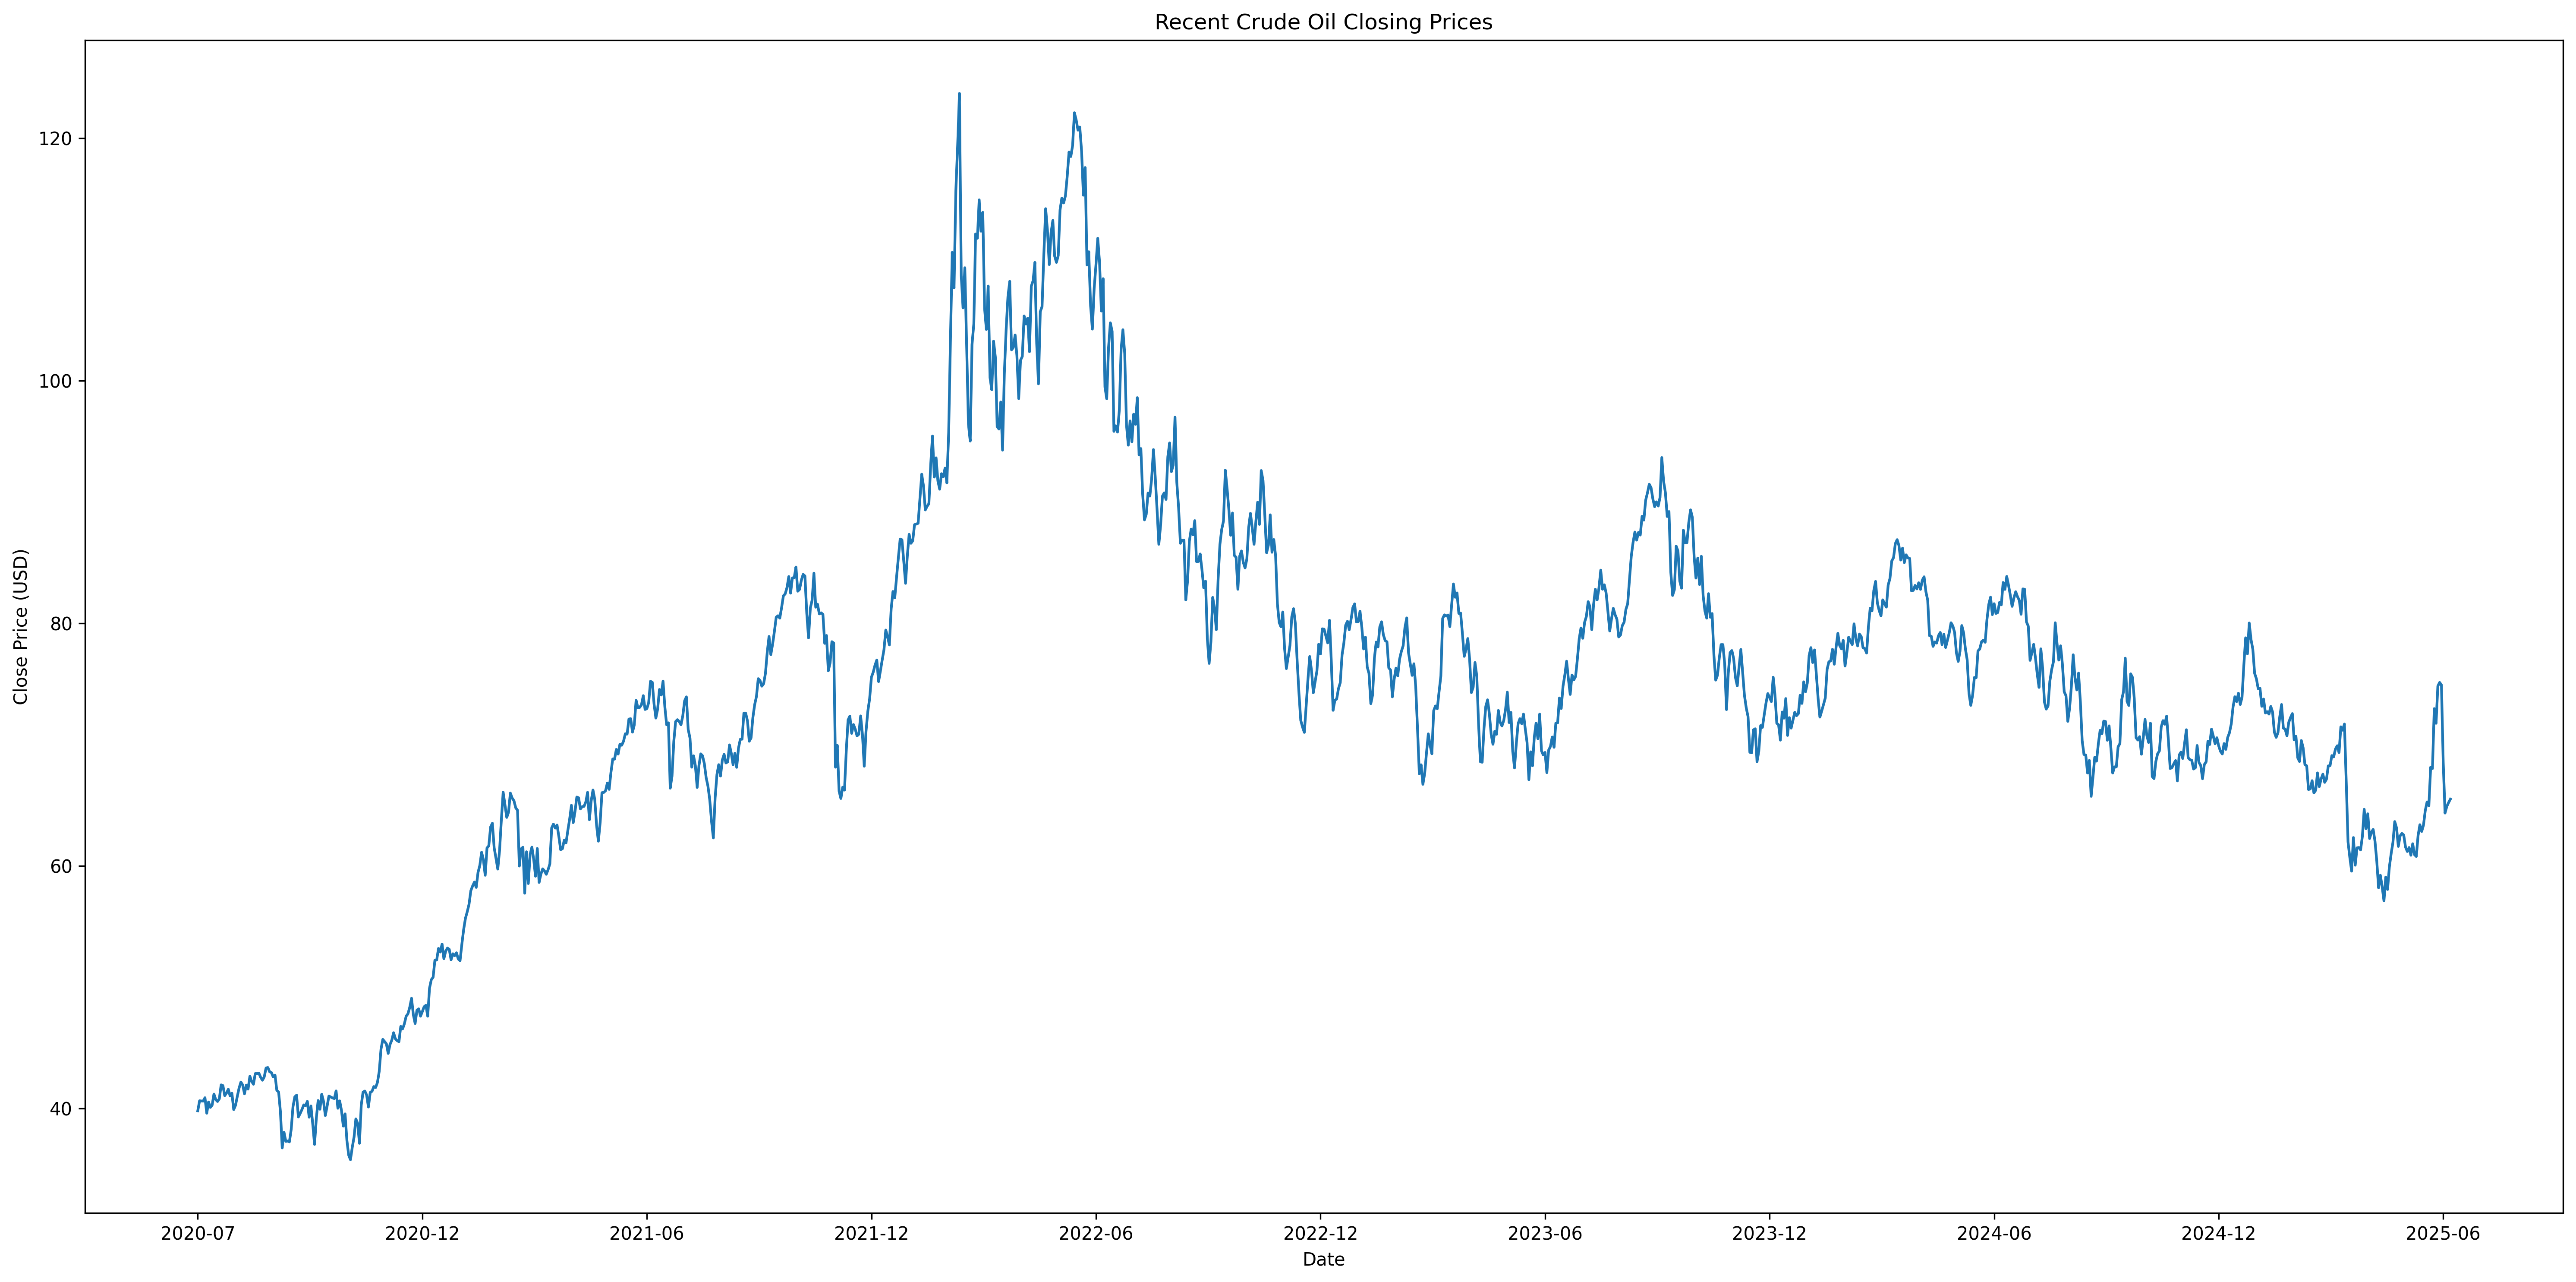

In [177]:
import datetime

recent_oil_df = pd.read_csv("data/crude_oil_prices.csv", header = 0, index_col = 0)

recent_oil_df = recent_oil_df.iloc[2:]

recent_oil_df.head()

figure(figsize = (20, 10), dpi = 300)

plot(recent_oil_df.index, recent_oil_df["Close"].astype(float))
title("Recent Crude Oil Closing Prices")
xlabel("Date")
ylabel("Close Price (USD)")
# Convert the index to datetime if not already
recent_oil_df.index = pd.to_datetime(recent_oil_df.index)

# Show only year and month in x-ticks for clarity

days = len(recent_oil_df.index)

xticks(
	ticks = np.arange(0, days, days // 10),
	labels = [dt.strftime("%Y-%m") for dt in recent_oil_df.index[::days // 10]]
)

# xticks(recent_oil_df.index.strftime(date_format = "%Y-%m"))

tight_layout()

show()

In [266]:
predictions_int = arma_model_fit.get_forecast(steps = 730, typ = "levels")

CI_df = pd.concat([predictions_int.predicted_mean, predictions_int.conf_int()], axis = 1)

CI_df["predicted"] = cleaned_df["Price"].iloc[-1] + inv_boxcox(CI_df["predicted_mean"], lam)
CI_df["lower"] = CI_df["predicted"].iloc[-1] + inv_boxcox(CI_df["lower Price_Diff"], lam)
CI_df["upper"] = CI_df["predicted"].iloc[-1] + inv_boxcox(CI_df["upper Price_Diff"], lam)

CI_df.head()

/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/admin/Downloads/Code/AdvanceResearch/env/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


,predicted_mean,lower Price_Diff,upper Price_Diff,predicted,lower,upper
634,0.012641,-0.727290,0.752571,83.832671,84.213951,85.688636
635,0.061773,-0.678232,0.801778,83.882502,84.248401,85.751423
636,-0.132717,-0.875088,0.609653,83.690699,84.117253,85.510860
637,0.062967,-0.681681,0.807615,83.883724,84.245942,85.758925
638,-0.040808,-0.785698,0.704081,83.779512,84.174445,85.627550


In [267]:
# last observed Box-Cox level
base_bc = cleaned_df["Price_Boxcox"].iloc[-1]

# series returned by statsmodels: Δ(BoxCox) forecasts
fc_diff_bc   = predictions_int.predicted_mean
ci_low_diff  = predictions_int.conf_int()["lower Price_Diff"]
ci_up_diff   = predictions_int.conf_int()["upper Price_Diff"]

# integrate (cumulative sum) in Box-Cox space
fc_level_bc  = base_bc + fc_diff_bc
ci_low_bc    = base_bc + ci_low_diff
ci_up_bc     = base_bc + ci_up_diff

# back to USD
CI_df = pd.DataFrame({
    "predicted": inv_boxcox(fc_level_bc, lam),
    "lower"    : inv_boxcox(ci_low_bc,  lam),
    "upper"    : inv_boxcox(ci_up_bc,  lam)
})

CI_df.head()

,predicted,lower,upper
634,82.888875,78.894396,86.958647
635,83.156786,79.156883,87.231941
636,82.098196,78.105611,86.166740
637,83.163303,79.138418,87.264386
638,82.597799,78.582312,86.689653


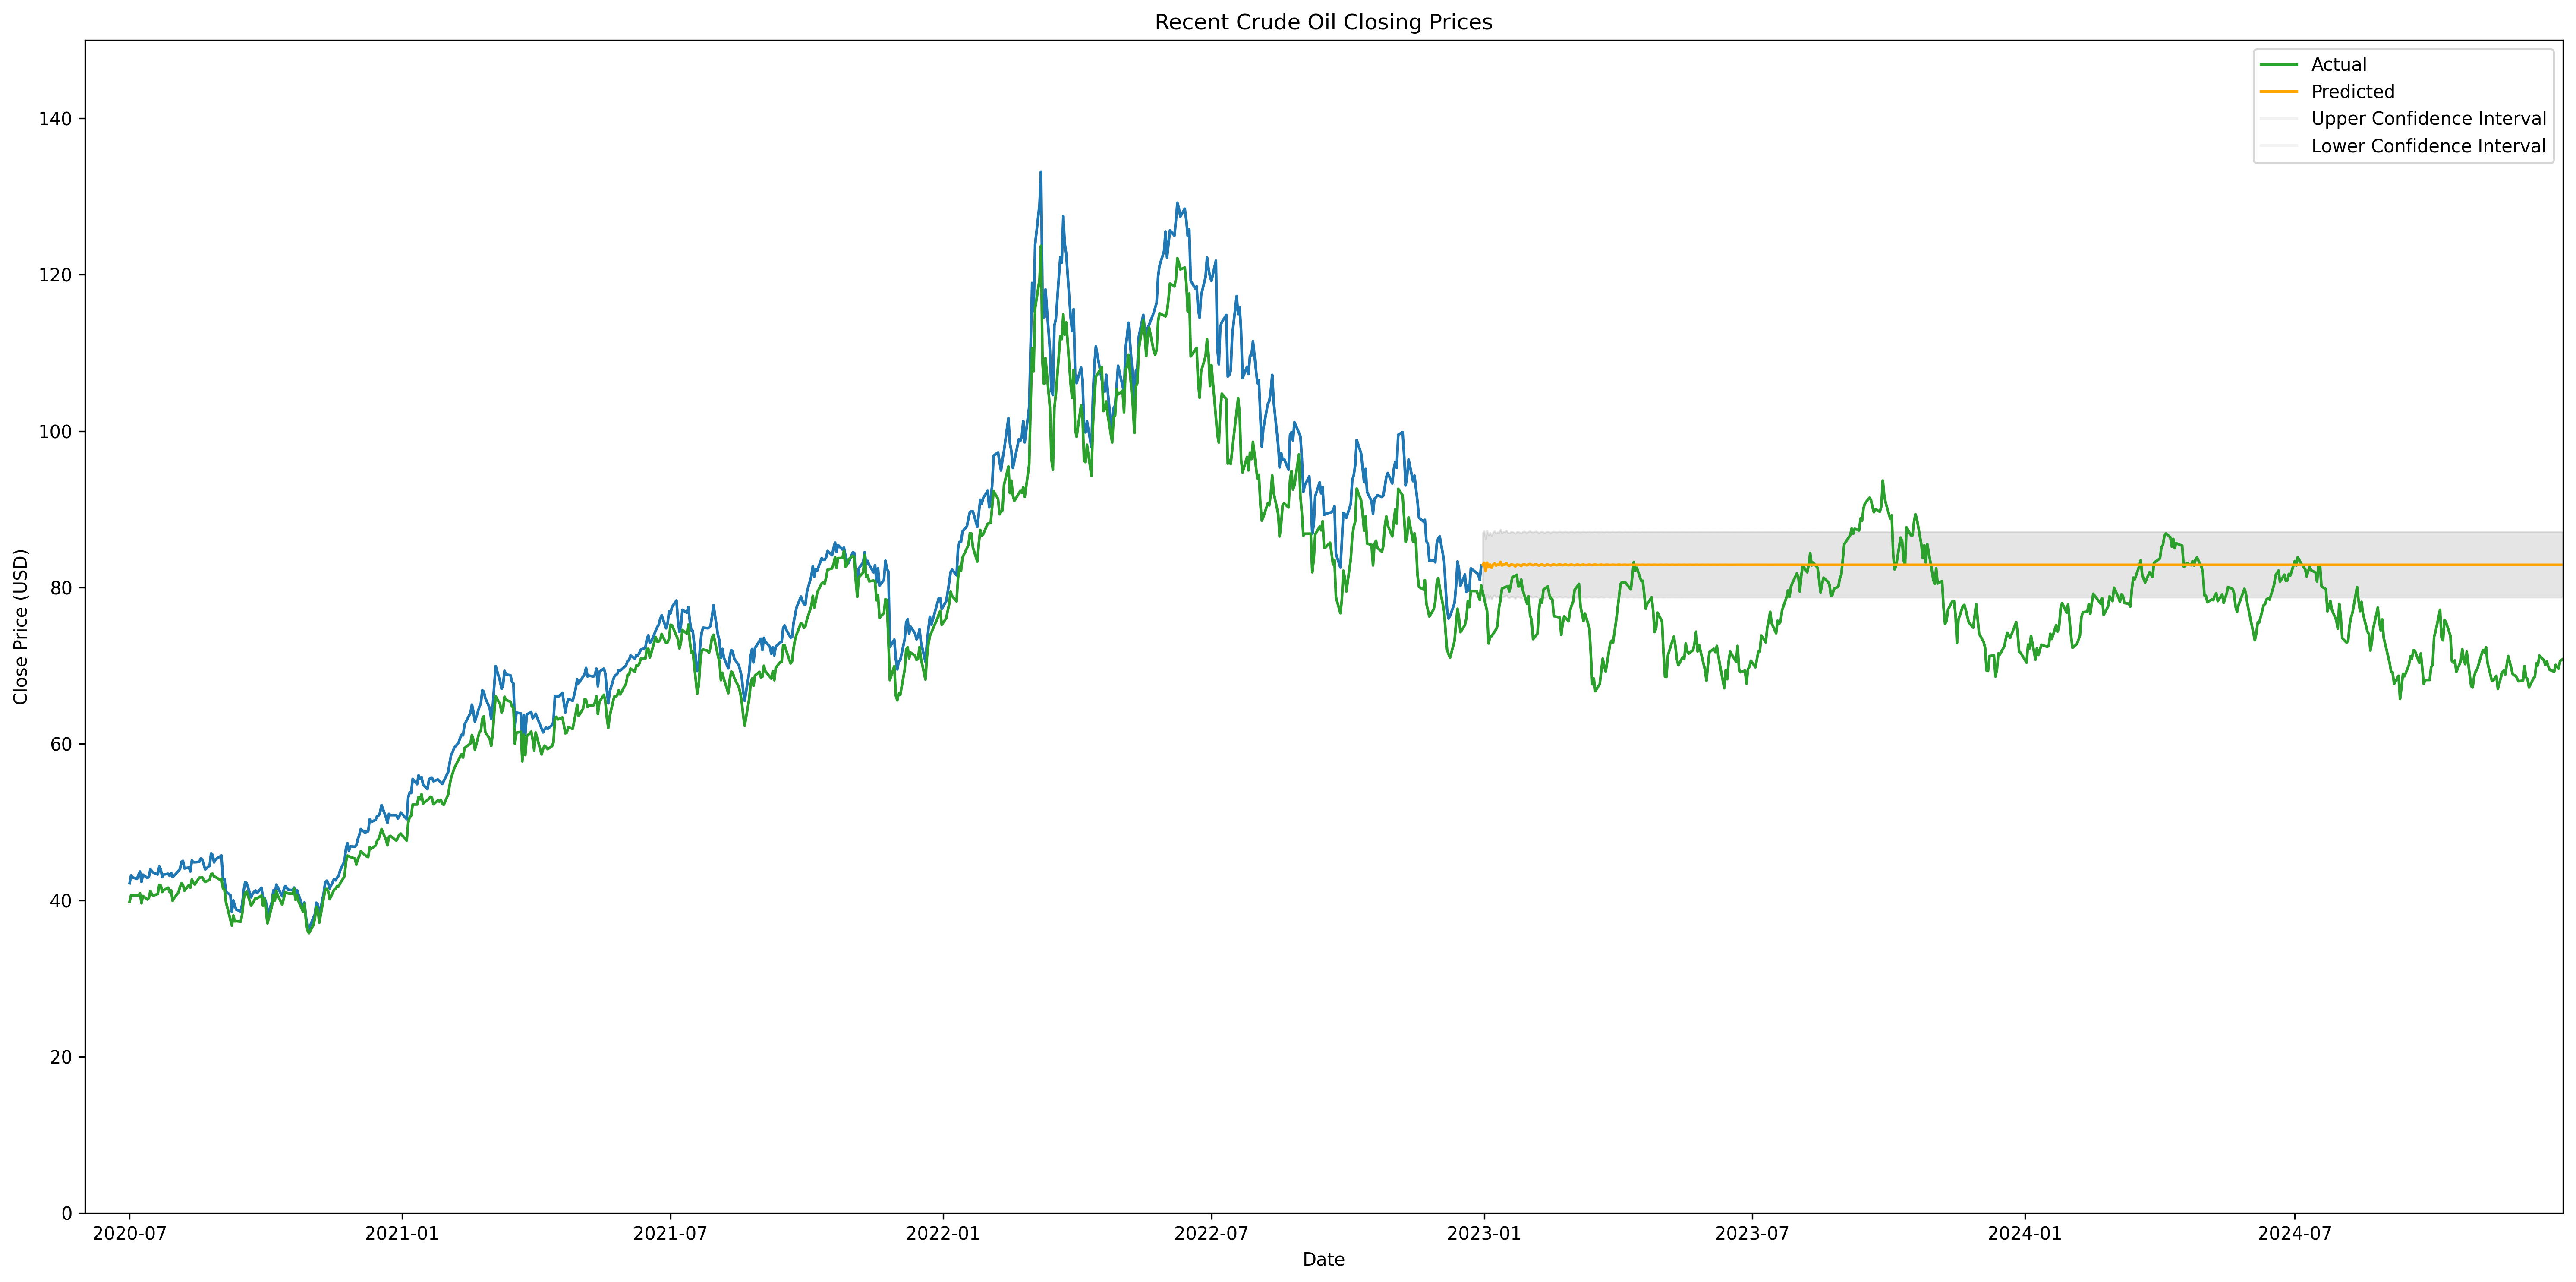

In [282]:
fig, ax = subplots(figsize = (20, 10), dpi = 300)

ax.plot(cleaned_df["Price"])

title("Recent Crude Oil Closing Prices")

xlabel("Date")
ylabel("Close Price (USD)")

recent_oil_df.index = pd.to_datetime(recent_oil_df.index)

x = pd.date_range(start = cleaned_df.index[-1] + 
                  pd.Timedelta('1D'), periods = n_forecast, freq = 'D')

upper = CI_df['upper']
lower = CI_df['lower']

plot(recent_oil_df.index, recent_oil_df["Close"].astype(float), label = "Actual", color = "C2")
plot(x, CI_df['predicted'], color = 'orange',label = 'Predicted' )
upper.plot(color = 'grey', label = 'Upper Confidence Interval', alpha = 0.1)
lower.plot(color = 'grey', label = 'Lower Confidence Interval', alpha = 0.1)

ax.fill_between(x, lower, upper, color='grey', alpha = 0.2)

days = len(recent_oil_df.index)

ax.set_xlim(pd.Timestamp('2020-06-01'), x[-1])
ax.set_ylim(0, 150)

tight_layout()

legend()

show()

<h1>Method 2 - Generative Adversarial Networks</h1>

In [269]:
import math
import torch
import datetime
import pandas as pd
from torch import nn
from torch.optim import optimizer

In [270]:
oil_df = pd.read_csv("data/oil_price.csv", header = 0)

oil_df = oil_df.dropna()

oil_df.Date = pd.to_datetime(oil_df.Date)

oil_df["Date_unix"] = oil_df.Date.apply(lambda x: x.timestamp())

min_d = oil_df["Date_unix"].min()
min_p = oil_df["Price"].min()

max_d = oil_df["Date_unix"].max()
max_p = oil_df["Price"].max()


norm = lambda x: (x - min_d) / (max_d - min_d)
denorm = lambda x: x * (max_d - min_d) + min_d

oil_df["Date_unix"] = oil_df["Date_unix"].apply(norm)

oil_df = oil_df[["Date_unix", "Price", "Date"]]

oil_df.head(10)

,Date_unix,Price,Date
0,0.000000,42.18,2020-07-01
1,0.001096,43.19,2020-07-02
2,0.002193,42.92,2020-07-03
3,0.005482,42.73,2020-07-06
4,0.006579,43.28,2020-07-07
5,0.007675,43.67,2020-07-08
6,0.008772,42.35,2020-07-09
7,0.009868,43.27,2020-07-10
8,0.013158,42.85,2020-07-13
9,0.014254,42.97,2020-07-14


In [271]:
torch.manual_seed(42)

In [ ]:
train_data = oil_df[["Date_unix", "Price"]]

train_data_len = len(train_data)

train_labels = torch.zeros(train_data_len)

In [56]:
# train_labels = oil_df.index

# len(train_labels)

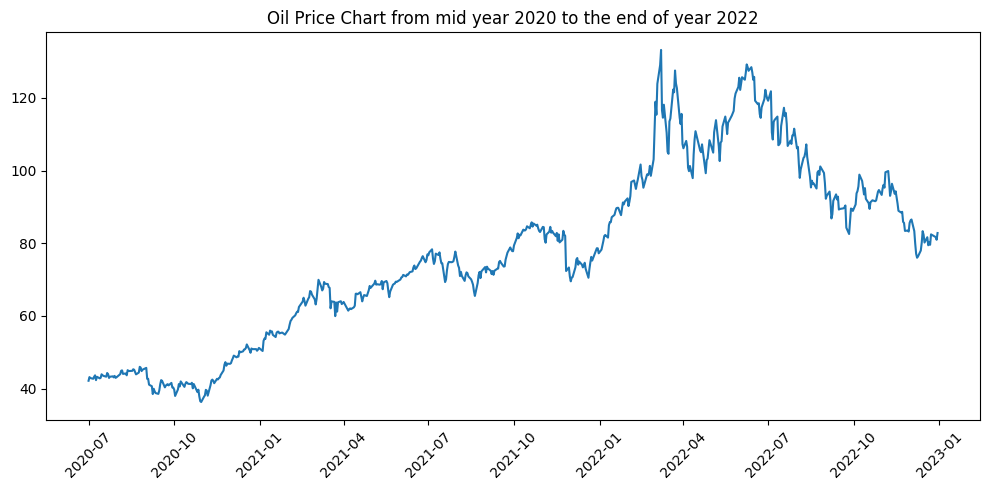

In [57]:
make_ts_plot(oil_df.Price, index = oil_df.Date)

In [89]:
train_set = [(torch.tensor((val[0].astype("float32"), val[1].astype("float32"))), train_labels[row].float()) for row, val in train_data.iterrows()]

/var/folders/7n/5wfxxtqx41zcc7qqdj_8rcl80000gn/T/ipykernel_20326/279607072.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_set = [(torch.tensor((val[0].astype("float32"), val[1].astype("float32"))), train_labels[row].float()) for row, val in train_data.iterrows()]


In [59]:
train_set??

Type:        list
String form: [(tensor([ 0.0000, 42.1800]), tensor(0.)), (tensor([1.0965e-03, 4.3190e+01]), tensor(0.)), (tensor([2.1930e-03, 4.2920e+01]), tensor(0.)), (tensor([5.4825e-03, 4.2730e+01]), tensor(0.)), (tensor([6.5789e-03, 4.3280e+01]), tensor(0.)), (tensor([7.6754e-03, 4.3670e+01]), tensor(0.)), (tensor([8.7719e-03, 4.2350e+01]), tensor(0.)), (tensor([9.8684e-03, 4.3270e+01]), tensor(0.)), (tensor([1.3158e-02, 4.2850e+01]), tensor(0.)), (tensor([1.4254e-02, 4.2970e+01]), tensor(0.)), (tensor([1.5351e-02, 4.3960e+01]), tensor(0.)), (tensor([1.6447e-02, 4.3710e+01]), tensor(0.)), (tensor([1.7544e-02, 4.3530e+01]), tensor(0.)), (tensor([2.0833e-02, 4.3300e+01]), tensor(0.)), (tensor([2.1930e-02, 4.4310e+01]), tensor(0.)), (tensor([2.3026e-02, 4.3980e+01]), tensor(0.)), (tensor([2.4123e-02, 4.2960e+01]), tensor(0.)), (tensor([2.5219e-02, 4.3290e+01]), tensor(0.)), (tensor([2.8509e-02, 4.3390e+01]), tensor(0.)), (tensor([2.9605e-02, 4.3110e+01]), tensor(0.)), (tensor([3.070

In [60]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size = batch_size, shuffle = True, drop_last = True
)

In [61]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
			nn.Dropout(0.3),
			nn.Linear(128, 64),
			nn.ReLU(),
			nn.Dropout(0.3),
			nn.Linear(64, 1),
			nn.Sigmoid(),            
		)

    def forward(self, x):
        output = self.model(x)
        return output

In [62]:
disc = Discriminator()

In [63]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        output = self.model(x)
        return output
    
gen = Generator()

In [ ]:
log = []
rate = 0.001
num_epochs = 2000
loss_function = nn.BCELoss()
optimizer_gen = torch.optim.Adam(gen.parameters(), lr = rate)
optimizer_disc = torch.optim.Adam(disc.parameters(), lr = rate)

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator.
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = gen(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator.
        disc.zero_grad()
        output_disc = disc(all_samples)
        loss_disc = loss_function(output_disc, all_samples_labels)
        loss_disc.backward()
        optimizer_disc.step()

        latent_space_samples = torch.randn(batch_size, 2)

        gen.zero_grad()
        generated_samples = gen(latent_space_samples)
        output_disc_gen = disc(generated_samples)
        loss_gen = loss_function(output_disc_gen, real_samples_labels)
        loss_gen.backward()
        optimizer_gen.step()

        print_epoch_num = 100
        # print(n, batch_size)

        if epoch % print_epoch_num == 0 and n == (batch_size / 2) + 2:
            print(f"Epoch: {epoch} Loss D.: {loss_disc}")
            print(f"Epoch: {epoch} Loss G.: {loss_gen}")
            torch.save(gen.state_dict(), f"data/gen_{epoch}.pth")
            
        if n == 0:
            log.append((epoch,
                        loss_disc.item(),
                        loss_gen.item()))
						
df = pd.DataFrame(log, columns = ["epoch", "loss_D", "loss_G"])
df.to_csv("gan_training_log.csv", index = False)

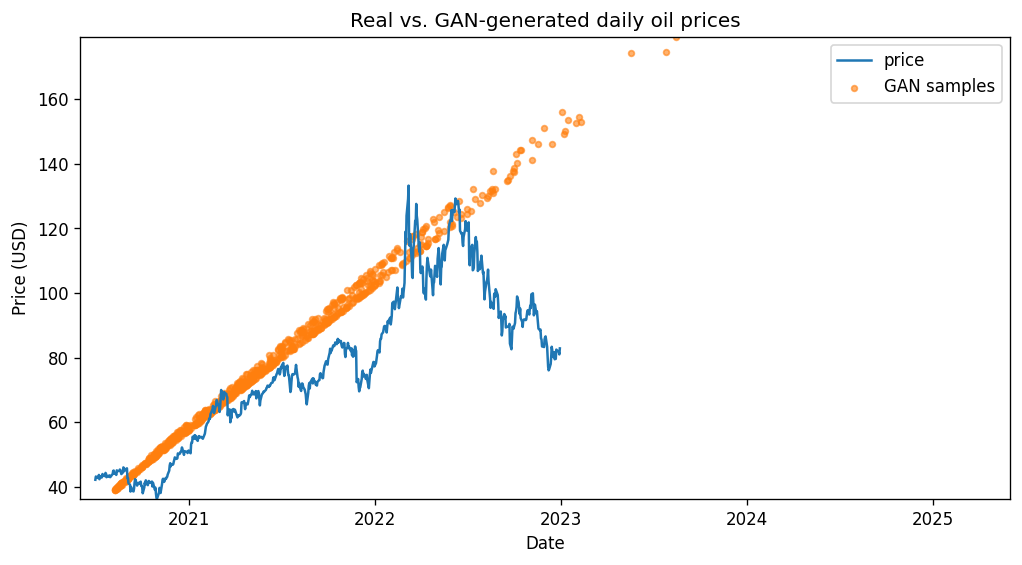

In [279]:
n_samples = 730
z = torch.randn(n_samples, 2)                
gen_norm = gen(z).detach().cpu().numpy()     

date_gen_unix   = gen_norm[:, 0] * (max_d - min_d) + min_d
price_gen_usd   = gen_norm[:, 1]

date_real_unix  = oil_df["Date_unix"].values
price_real_usd  = oil_df["Price"].values

date_gen_dt  = pd.to_datetime(date_gen_unix, unit = "s")
date_real_dt = pd.to_datetime(date_real_unix, unit = "s")

figure(figsize = (10,5), dpi = 120)
plot(oil_df["Date"], oil_df["Price"], c = "C0", label = "price")

scatter(date_gen_dt,  price_gen_usd,
		s = 12, c = "C1",  alpha = 0.6, label = "GAN samples")
title("Real vs. GAN-generated daily oil prices")

xlim(pd.Timestamp('2020-06-01'), pd.Timestamp('2025-06-01'))
ylim(price_real_usd.min(), price_gen_usd.max())

xlabel("Date")
ylabel("Price (USD)")

legend()

show()